# Figure 5a: H5N1 within-host shared SNVs calculation

June 6, 2019 

We wanted to determine whether there was any evidence for convergent evolution in our samples. If there is strong selection at a particular set of sites, then we might imagine that the same mutation could arise at that site in multiple independent spillovers. Because each human case of H5N1 is thought to represent a unique cross-species transmission event, each human infection can be conceptualized as a unique evolution experiment. In this notebook, I iterate through all of the variants detected in coding regions in humans and ducks, and determine whether there are any amino acid sites at which a mutation arises in multiple hosts. I also generate the code to plot **Figure 5a.**

In [2]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

duck_nonsyn_color = "#545AB7"
duck_syn_color = "#98B4DA"
human_nonsyn_color = "#C75643"
human_syn_color = "#E6B692"

In [3]:
# variant calls file to load in
variant_calls = "../data/within-host-variants-1%.tsv"

In [4]:
# read in dataframe
snps_df = pd.read_csv(variant_calls, sep='\t', header='infer')

# get rid of the incorrect variant call due to a mismatched reference base
snps_df = snps_df[snps_df['coding_region_change'] != 'Xaa240Gly']

# change NAs to neuramindase
snps_df['gene'].fillna('neuraminidase', inplace=True)

snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [5]:
# Add a few columns, separating out the amino acid site from the coding region change column. 
# This will make parsing easier.
snps_df['original_aa'] = snps_df['coding_region_change'].replace('([A-z*]{3})([0-9]+)[A-z*]{3}', '\\1', regex=True)
snps_df['amino_acid_site_change'] = snps_df['coding_region_change'].replace('[A-z*]{3}([0-9]+)[A-z*]{3}', '\\1', regex=True)
snps_df['aa_site'] = snps_df['coding_region_change'].replace('[A-z*]{3}([0-9]+)[A-z*]{3}', '\\1', regex=True)
snps_df['new_aa'] = snps_df['coding_region_change'].replace('([A-z*]{3})([0-9]+)([A-z*]{3})', '\\3', regex=True)
snps_df['amino_acid_site_change'] = snps_df['gene'] + " " + snps_df['amino_acid_site_change'] + " " + snps_df['new_aa']
snps_df['amino_acid_site'] = snps_df['gene'] + " " + snps_df['aa_site']
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10,original_aa,amino_acid_site_change,aa_site,new_aa,amino_acid_site
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN,Ala,HA 265 Thr,265,Thr,HA 265
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN,Gln,NP 117 Arg,117,Arg,NP 117
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN,Ala,PA 307 Ala,307,Ala,PA 307
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN,Arg,PA 367 Lys,367,Lys,PA 367
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN,Pro,PA 530 Pro,530,Pro,PA 530


In [6]:
# select only the 3 columns we want, and transpose dataframe
df = snps_df[['sample','frequency','amino_acid_site']]
df_pivot = df.pivot_table(index='sample', columns='amino_acid_site', values='frequency')
df_pivot

amino_acid_site,HA 102,HA 129,HA 141,HA 142,HA 150,HA 166,HA 171,HA 172,HA 173,HA 176,...,neuraminidase 344,neuraminidase 353,neuraminidase 364,neuraminidase 374,neuraminidase 418,neuraminidase 433,neuraminidase 47,neuraminidase 58,neuraminidase 91,neuraminidase 96
sample,,,,,,,,,,,,,,,,,,,,,
A/CAMBODIA/V0401301/2011,NaN,NaN,0.0756,NaN,0.2024,0.0428,0.033,NaN,0.0504,0.0426,...,0.03335,NaN,0.0242,0.0309,NaN,NaN,NaN,NaN,NaN,NaN
A/CAMBODIA/V0417301/2011,NaN,NaN,0.1750,0.032,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0889,NaN,0.037,NaN
A/Cambodia/W0112303/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A/Cambodia/X0125302/2013,NaN,NaN,NaN,NaN,0.1509,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0463,NaN,NaN,NaN,NaN
A/Cambodia/X0128304/2013,NaN,NaN,0.0569,NaN,NaN,NaN,NaN,0.115,NaN,NaN,...,NaN,0.0451,NaN,NaN,0.0252,NaN,NaN,NaN,NaN,NaN
A/Cambodia/X0207301/2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A/Cambodia/X0219301/2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A/Cambodia/X1030304/2013,0.0179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A/duck/Cambodia/083D1/2011,NaN,0.0963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1789,NaN,0.1795


In [7]:
# output the number of columns with only a single entry 
singles = (df_pivot.count(numeric_only=True) == 1).sum()
singles

205

In [8]:
# output the number of columns with multiple entries (were present in multiple samples) 
non_singles = (df_pivot.count(numeric_only=True) != 1).sum()
non_singles

13

In [9]:
# convert NaNs to 0s
df_pivot = df_pivot.replace(np.nan,0, regex=False)
df_pivot.head()

amino_acid_site,HA 102,HA 129,HA 141,HA 142,HA 150,HA 166,HA 171,HA 172,HA 173,HA 176,...,neuraminidase 344,neuraminidase 353,neuraminidase 364,neuraminidase 374,neuraminidase 418,neuraminidase 433,neuraminidase 47,neuraminidase 58,neuraminidase 91,neuraminidase 96
sample,,,,,,,,,,,,,,,,,,,,,
A/CAMBODIA/V0401301/2011,0.0,0.0,0.0756,0.000,0.2024,0.0428,0.033,0.000,0.0504,0.0426,...,0.03335,0.0000,0.0242,0.0309,0.0000,0.0000,0.0000,0.0,0.000,0.0
A/CAMBODIA/V0417301/2011,0.0,0.0,0.1750,0.032,0.0000,0.0000,0.000,0.000,0.0000,0.0000,...,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0889,0.0,0.037,0.0
A/Cambodia/W0112303/2012,0.0,0.0,0.0000,0.000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,...,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,0.0
A/Cambodia/X0125302/2013,0.0,0.0,0.0000,0.000,0.1509,0.0000,0.000,0.000,0.0000,0.0000,...,0.00000,0.0000,0.0000,0.0000,0.0000,0.0463,0.0000,0.0,0.000,0.0
A/Cambodia/X0128304/2013,0.0,0.0,0.0569,0.000,0.0000,0.0000,0.000,0.115,0.0000,0.0000,...,0.00000,0.0451,0.0000,0.0000,0.0252,0.0000,0.0000,0.0,0.000,0.0


### subset dataframe to include only columns with > 1 entry 

In [10]:
# take the df_pivot indices (samples) and write out to the list, "samples"
samples = list(df_pivot.index)

# make a new dataframe, with the samples list and set the indices to samples
nonsingles_df = pd.DataFrame(samples, columns=['samples']).set_index(['samples'])

# loop through all of the columns in df_pivot; if that column contains 13 0s, move on; 
# not, then add it as a new column in df2
for c in df_pivot.columns:
    if ((df_pivot[c] == 0).sum()) <= len(samples) - 2:
        nonsingles_df[c] = df_pivot[c] 
        
nonsingles_df.reset_index(inplace=True)
pd.options.display.max_columns = 4000
nonsingles_df

,samples,HA 141,HA 150,HA 238,HA 265,HA 307,HA 357,M1 199,NP 201,NS1 92,PA 237,PA 307,PB1 371,PB2 441
0,A/CAMBODIA/V0401301/2011,0.0756,0.2024,0.0280,0.0000,0.0000,0.0000,0.0000,0.0281,0.0000,0.0234,0.0467,0.0433,0.0000
1,A/CAMBODIA/V0417301/2011,0.1750,0.0000,0.0845,0.0000,0.0000,0.0635,0.0000,0.0000,0.0000,0.0436,0.0438,0.0000,0.0000
2,A/Cambodia/W0112303/2012,0.0000,0.0000,0.0000,0.0562,0.0000,0.0000,0.0000,0.0000,0.0000,0.0364,0.0285,0.0000,0.0000
3,A/Cambodia/X0125302/2013,0.0000,0.1509,0.4030,0.0000,0.0000,0.0000,0.0000,0.0000,0.0249,0.0000,0.0250,0.0000,0.0000
4,A/Cambodia/X0128304/2013,0.0569,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2906,0.0000,0.0000,0.0000,0.0000
5,A/Cambodia/X0207301/2013,0.0000,0.0000,0.0000,0.0000,0.1982,0.0583,0.0000,0.0000,0.0000,0.0000,0.0280,0.0315,0.0000
6,A/Cambodia/X0219301/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0237,0.0000,0.0000
7,A/Cambodia/X1030304/2013,0.0000,0.0000,0.0000,0.0000,0.0665,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,A/duck/Cambodia/083D1/2011,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0292,0.0000,0.0000,0.0000,0.0000,0.0271,0.0000
9,A/duck/Cambodia/381W11M4/2013,0.0000,0.0000,0.0000,0.0328,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0455,0.0000,0.0319


In [11]:
# put data back into long format and split up sites column
nonsingles_melted = pd.melt(nonsingles_df, id_vars=['samples'])
nonsingles_melted.head()

,samples,variable,value
0,A/CAMBODIA/V0401301/2011,HA 141,0.0756
1,A/CAMBODIA/V0417301/2011,HA 141,0.1750
2,A/Cambodia/W0112303/2012,HA 141,0.0000
3,A/Cambodia/X0125302/2013,HA 141,0.0000
4,A/Cambodia/X0128304/2013,HA 141,0.0569


In [12]:
# split site ("variable") into 2 columns, gene, and site; convert site to numeric
nonsingles_melted[['gene','site']] = nonsingles_melted.variable.str.replace(' ', ' ').str.rsplit(n=3, expand=True)
nonsingles_melted['site'] = nonsingles_melted['site'].apply(pd.to_numeric, errors='coerce')
nonsingles_melted.head()

,samples,variable,value,gene,site
0,A/CAMBODIA/V0401301/2011,HA 141,0.0756,HA,141
1,A/CAMBODIA/V0417301/2011,HA 141,0.1750,HA,141
2,A/Cambodia/W0112303/2012,HA 141,0.0000,HA,141
3,A/Cambodia/X0125302/2013,HA 141,0.0000,HA,141
4,A/Cambodia/X0128304/2013,HA 141,0.0569,HA,141


In [13]:
# make a new column specifying bird or human
nonsingles_melted['species'] = np.where(nonsingles_melted['samples'].str.contains('duck'), 'duck', 'human')
nonsingles_melted.head()

,samples,variable,value,gene,site,species
0,A/CAMBODIA/V0401301/2011,HA 141,0.0756,HA,141,human
1,A/CAMBODIA/V0417301/2011,HA 141,0.1750,HA,141,human
2,A/Cambodia/W0112303/2012,HA 141,0.0000,HA,141,human
3,A/Cambodia/X0125302/2013,HA 141,0.0000,HA,141,human
4,A/Cambodia/X0128304/2013,HA 141,0.0569,HA,141,human


In [14]:
# convert 0s to Nans
nonsingles_melted = nonsingles_melted.replace(0,np.nan, regex=False)

In [15]:
nonsingles_melted['label'] = nonsingles_melted['gene'] + "\n"+ nonsingles_melted['site'].astype(str)
nonsingles_melted.head()

,samples,variable,value,gene,site,species,label
0,A/CAMBODIA/V0401301/2011,HA 141,0.0756,HA,141,human,HA\n141
1,A/CAMBODIA/V0417301/2011,HA 141,0.1750,HA,141,human,HA\n141
2,A/Cambodia/W0112303/2012,HA 141,NaN,HA,141,human,HA\n141
3,A/Cambodia/X0125302/2013,HA 141,NaN,HA,141,human,HA\n141
4,A/Cambodia/X0128304/2013,HA 141,0.0569,HA,141,human,HA\n141


In [16]:
# now need to get the synonymous/nonsynonymous information back for each SNP and each site. I will merge with 
# part of the original snps_df
to_merge = snps_df[['sample','synonymous_nonsynonymous','frequency','amino_acid_site']]
to_merge.columns = ['samples','syn_nonsyn','value','variable']
to_merge.head()

,samples,syn_nonsyn,value,variable
0,A/duck/Cambodia/381W11M4/2013,nonsynonymous,0.0328,HA 265
1,A/duck/Cambodia/381W11M4/2013,nonsynonymous,0.2043,NP 117
2,A/duck/Cambodia/381W11M4/2013,synonymous,0.0455,PA 307
3,A/duck/Cambodia/381W11M4/2013,nonsynonymous,0.1900,PA 367
4,A/duck/Cambodia/381W11M4/2013,synonymous,0.0438,PA 530


In [17]:
# merge 
to_plot = nonsingles_melted.merge(to_merge, on=['samples','value','variable'], how='left')
to_plot['color'] = to_plot['species'] + "_" + to_plot['syn_nonsyn']

# replace all NaNs with "human synonymous"; it doesn't matter, this won't get plotted, it just needs to not be an 
to_plot['color'] = to_plot['color'].replace(np.nan,"human_synonymous", regex=False)

pd.options.display.max_rows = 4000

to_plot.head()

,samples,variable,value,gene,site,species,label,syn_nonsyn,color
0,A/CAMBODIA/V0401301/2011,HA 141,0.0756,HA,141,human,HA\n141,nonsynonymous,human_nonsynonymous
1,A/CAMBODIA/V0417301/2011,HA 141,0.1750,HA,141,human,HA\n141,nonsynonymous,human_nonsynonymous
2,A/Cambodia/W0112303/2012,HA 141,NaN,HA,141,human,HA\n141,NaN,human_synonymous
3,A/Cambodia/X0125302/2013,HA 141,NaN,HA,141,human,HA\n141,NaN,human_synonymous
4,A/Cambodia/X0128304/2013,HA 141,0.0569,HA,141,human,HA\n141,synonymous,human_synonymous


## Plot Figure 5a 

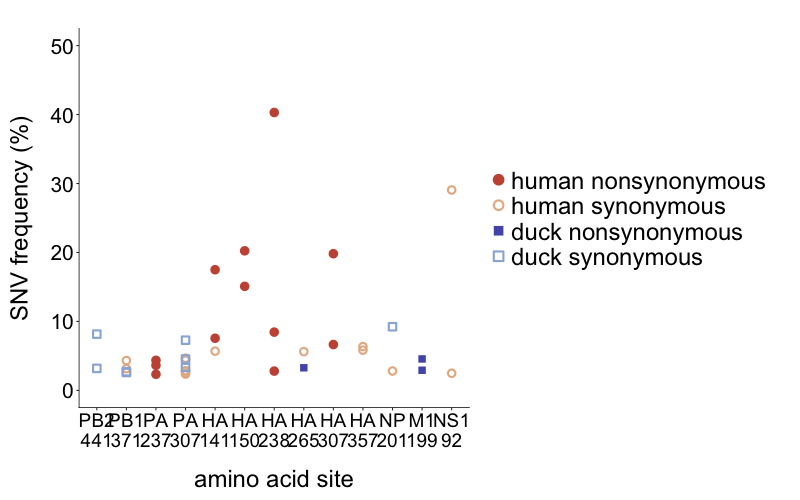

In [31]:
%%R -w 800 -h 500 -u px -i to_plot,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

to_plot$labelf = factor(to_plot$label, levels=c("PB2\n441","PB1\n371","PA\n237","PA\n307",
                                                          "HA\n141","HA\n150","HA\n238","HA\n265","HA\n307","HA\n357",
                                                          "NP\n201","M1\n199","NS1\n92"))

p <- ggplot(data=to_plot, aes(x=labelf, y=value*100, color=color, shape=color)) + 
    geom_point(size=2.5, stroke=1.5)+
    scale_color_manual(name="type",values=c(human_nonsynonymous=human_nonsyn_color,human_synonymous=human_syn_color,duck_nonsynonymous =duck_nonsyn_color,duck_synonymous =duck_syn_color),breaks = c("human_nonsynonymous","human_synonymous","duck_nonsynonymous","duck_synonymous"),labels = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"))+
    scale_shape_manual(name="type",values=c(human_nonsynonymous=19, human_synonymous=1,duck_nonsynonymous = 15, duck_synonymous = 0),breaks=c("human_nonsynonymous", "human_synonymous","duck_nonsynonymous","duck_synonymous"),labels = c("human nonsynonymous", "human synonymous","duck nonsynonymous","duck synonymous"), guide=FALSE)+
    guides(shape = guide_legend(ncol = 1, override.aes = list(size=3.5)))+ 
    labs(x="amino acid site",y="SNV frequency (%)")+
    scale_y_continuous(limits=c(0,50))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=24, vjust=8))+
    theme(axis.title.x=element_text(size=24, vjust=-6))+
    theme(axis.text.x=element_text(size=19, colour="black"))+
    theme(axis.text.y=element_text(size=21, colour="black"))+
    theme(legend.text=element_text(size=24))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.9, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-5a-shared-aa-sites.pdf", p, width = 14, height = 5, path="figure-PDFs")
p